# Laboratorium 3

### Konfiguracja

In [4]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [5]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

Działanie programu:
- W pierwszym kroku należy wierzchołki wielkoątu którego chcemy poddać triangulacji <br>
- natępnie zostanie określona jego Y-monotoniczność <br>
- Opisane sotaną typy jego wierzvhołków <br>
- Nastąpi rozdział na łańcuch lewy i prawy <br>
- Natępuje wizualizaja triangulacji (zawierająca również poprzednie kroki) <br>

W komórce poniżej tworzona jest część interfejsu urzytkownika odopowiedzialna za pobranie wierzchołków wielokąta od użytkownika

In [6]:
# klasa analogiczna do Plot ale rysująca pole do wprowadzenia własnej figury
# przyjmuje punkty od urzytkownika a następnie ptzekazuje je do utworzenia z nich wielokąta
class PlotGetFigure:
    # domyślne punkty gwarantują nam wyświetlanie wielokąta w tej samej skali
    # nie zależnie od jego rozmiaru
    defaultPoints = [PointsCollection([(1,1), (10,10), (1, 10),(10, 1)],color = "white",marker="s")]
    def __init__(self, scenes = [Scene()], points = defaultPoints, lines = []):
            self.scenes = scenes
            PlotGetFigure.figure=[None]
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
    
    #potrzebny jest nam przycisk do wprowadzania punktów
    #oraz do zapisania wielokątu
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_add_point = plt.axes([0.2, 0.05, 0.35, 0.075])
        ax_figure = plt.axes([0.6, 0.05, 0.2, 0.075])
        b_figure = Button(ax_figure, 'Zapisz wielokąt')
        b_figure.on_clicked(self.figure_return)
        b_add_point = Button(ax_add_point, 'Dodaj wierzchołek wielokąta')
        b_add_point.on_clicked(self.callback.add_point)
        return [b_figure,b_add_point]
    # funckja zwracająca dodane punkty w postaci listy ktotek
    def figure_return(self):
        if len(self.get_added_points()) >= 0:
            PlotGetFigure.figure = self.get_added_points()[0].points
            plt.close()
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = True)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()



Poniżej komurka zawierająca punkcje pomocnicze potrzebne do prawidłowego działania reszty programu

In [7]:
#funkcja tworząca z listy punktów listę par sonsiednich punktów
#w celu utworzenia z nich odcinków
def LinesFromPoints(points):
    result = []
    i = 1
    while i < len(points):
        result.append([points[i-1],points[i]])
        i+=1
    result.append([points[i-1],points[0]])
    return result
#funckja tworząca z 3 punktów macierz potrzebną
#do określenia ich wzajemnej orientacji
def matrix_3x3(pointA,pointB,pointC):
    result = [[pointA[0],pointA[1],1], \
             [pointB[0],pointB[1],1],  \
             [pointC[0],pointC[1],1]]  
    return result
#obliczanie wyznacznika macierzy 3x3
#przy uwzględnieniu prezycji zdefiniowanej jako epsilon
def det_3x3(matrix,epsilon = 1e-10):
        res =((matrix[0][0]*matrix[1][1]*matrix[2][2]+
            matrix[0][1]*matrix[1][2]*matrix[2][0]+
            matrix[0][2]*matrix[1][0]*matrix[2][1])
            -(matrix[0][2]*matrix[1][1]*matrix[2][0]+
            matrix[0][0]*matrix[1][2]*matrix[2][1]+
            matrix[0][1]*matrix[1][0]*matrix[2][2]))
        if -epsilon<res<epsilon:
            return 0
        else:
            return res

Część kodu odpowiedzialna za klasyfikację wierzchołków do konkretnch typów, <br>
kolorowanie ich oraz sprawdzanie y-monotoniczności

In [8]:
#rzwraca typ wierzchołka B
#gdzie a i c są jego sąsiadami
#możlwe wartości otrzymane przez funkcję:
#P - początkowy,K-końcowy,Ł-łączący,PR - prawidłowy
def typeOfVert(a,b,c,epsilon = 1e-12):
    matrix = matrix_3x3(a,b,c)
    twoBelow = a[1] < b[1]and c[1] < b[1]
    twoAbove = a[1] > b[1]and c[1] > b[1]
    angleMoreThanPI = det_3x3(matrix) < -epsilon
    angleLessThanPI = det_3x3(matrix) > epsilon
    if angleMoreThanPI:
        if twoBelow:
            return "D"
        if twoAbove:
            return "Ł"
    if angleLessThanPI:
        if twoBelow:
            return "P"
        if twoAbove:
            return "K"
    return "PR"
#sprawdza y- monotoniczność wielokąta korzystając z faktu, że 
#wielokąt y-monotoniczny nie może zawierać wierzchołków łączących
#oraz wierzchołków dzielących
def Ymonotone(points):
    points = points[:]
    for i in range(0,len(points)-1):
        type = typeOfVert(points[i-1],points[i],points[i+1])
        if type == "D" or type =="Ł":
            return False
    type = typeOfVert(points[-2],points[-1],points[0])
    if type == "D" or type =="Ł":
        return False 
    return True
#funkcja kolorująca wszystkie wierzchołki
#iteruje się po wszystkich wierzchołkach sprawdza typ każedgo z nich
#a następnie dodaje do listy scen scene zawierającacą nowo pokolorowany wierzchołek
def TypeColor(points,lines):
    points = points[:]
    pointsK = []
    pointsD = []
    pointsL = []
    pointsP = []
    pointsPR = []
    Scenes = []
    lines = [LinesCollection(lines)]
    defaultPoints = PointsCollection([(1,1), (10,10), (1, 10),(10, 1)],color = "white",marker="s")
    PointsToPrint = [PointsCollection(points,),defaultPoints]
    Scenes.append(Scene(points=PointsToPrint,lines=lines))
    for i in range(0,len(points)-1):
        
        type = typeOfVert(points[i-1],points[i],points[i+1])
        if type == "K":
            pointsK.append(points[i])
        elif type == "Ł":
            pointsL.append(points[i])
        elif type == "P":
            pointsP.append(points[i])
        elif type == "D":
            pointsD.append(points[i])
        else:
            pointsPR.append(points[i])
            
        PointsToPrint = [PointsCollection(pointsK,color="red"),PointsCollection(pointsD,color="royalblue"),
              PointsCollection(pointsL,color="darkblue"),PointsCollection(pointsP,color="green"),
              PointsCollection(pointsPR,color="brown"),PointsCollection(points[i+1:]),defaultPoints]
        Scenes.append(Scene(points=PointsToPrint,lines=lines))
            
    type = typeOfVert(points[-2],points[-1],points[0])
    if type == "K":
        pointsK.append(points[-1])
    elif type == "Ł":
        pointsL.append(points[-1])
    elif type == "P":
        pointsP.append(points[-1])
    elif type == "D":
        pointsD.append(points[-1])
    else:
        pointsPR.append(points[-1])
    
    PointsToPrint = [PointsCollection(pointsK,color="red"),PointsCollection(pointsD,color="royalblue"),
              PointsCollection(pointsL,color="darkblue"),PointsCollection(pointsP,color="green"),
              PointsCollection(pointsPR,color="brown"),defaultPoints]
    Scenes.append(Scene(points=PointsToPrint,lines=lines))
    return Scenes

Funkcje potrzebne do podziału figury na łańcuch lewy i prawy a następnie
pokolorowanie poszczególnych łańcuchów

In [9]:
#funkcja tworząca z dwuch zbiorów punktów zbiory lini
#a następnie kolorująca je na dwa różne kolory
def twoStringToLines(a,b,color1="red",color2="green"):
    result = []
    rightLines=LinesFromPoints(a)[:-1]
    leftLines=LinesFromPoints(b)[:-1]
    rightLines.append((max(a,key = lambda x:x[1]),max(b,key = lambda x:x[1])))
    leftLines.append((min(a,key = lambda x:x[1]),min(b,key = lambda x:x[1])))
    result.append(LinesCollection(rightLines,color =color1))
    result.append(LinesCollection(leftLines,color = color2))
    return result
#funckja rozdzielająca figórę na łańcuch lewy i prawy
#na podstawie lokalizacji najwyższego i najniższego punktu figury
def leftRightString(points):
    upperCorner = max(points,key = lambda x: x[1])
    bottomCorner = min(points,key = lambda x: x[1])
    idUpper = points.index(upperCorner)
    idLower= points.index(bottomCorner)
    left = []
    right = []
    if idUpper > idLower:
        left = points[idLower : idUpper]
        right = points[idUpper:] + points[:idLower]
    else :
        left = points[idLower:]+points[:idUpper]
        right = points[idUpper:idLower]
    return [PointsCollection(left,color=color1),PointsCollection(right,color=color2)]

Funckja realizująca właściwe działanie programu czyli triangulację jednocześnie 
przeprowadzająca kolorowanie wierzchołków i łańcuchów figóry

In [31]:
def traiangulacja(points):
    #rysowanie wielokąta z punktów
    lines = [LinesCollection(LinesFromPoints(points))]
    points = [PointsCollection(points)]
    defaultPoints = [PointsCollection([(1,1), (10,10), (1, 10),(10, 1)],color = "white",marker="s")]
    #najrpierw same punkty
    scenes=[Scene(points= (points + defaultPoints))]
    #teraz dodajemy krawędzie wielokąta
    scenes.append(Scene(points= (points + defaultPoints),lines = lines))
    #kolorowanie punktów według typu
    scenes+=TypeColor(points=points[0].points,lines = lines[0].lines)[1:]
    #sprawdzenie monotonicznośći
    #jeśli nie przejdzie testu na monotniczność triangulacja nie będzie przeprowadzana
    if Ymonotone(points[0].points):
        print("jest Y monotoniczny")
        #zaznaczenie lewego i prawego łańcucha
        tmpPoints = leftRightString(points[0].points)
        linie = twoStringToLines(tmpPoints[0].points,tmpPoints[1].points)
        lastScene = scenes[-1]
        scenes.append(Scene(points=lastScene.points,lines=linie))
        #inicjalizacja stosu
        stack = []
        #posortowanie lewego i prawego łańcucha po malejącej współżędnej y-kowej
        #i oznacznie punktów w każdym z łańcuchów metką ułatwiającą puźniejsze sprawdzenie na stosie
        #do którego łańcucha należał wierzchołek
        leftString = tmpPoints[1].points
        rightString = tmpPoints[0].points
        leftString.sort(key = lambda x : x[1],reverse=True)
        leftString = [x+("l",) for x in leftString]
        rightString.sort(key = lambda x : x[1],reverse=True)
        rightString = [x+("r",) for x in rightString]
        leftid = 0
        rightid = 0
        diagonals = []
        #iteracja po posortowanych łańcuchach i dodawanie kolejnych przekątnych
        #zgodnie z warunkami algorytmu
        #przy jednoczesnym wizualizowaniu wierzchołków aktualnie na stosie
        while leftid + rightid < len(points[0].points)-1:
            if leftid<len(leftString) and leftString[leftid][1] > rightString[rightid][1]:
                if leftid + rightid < 2:
                    stack.append(leftString[leftid])
                else:
                    if leftString[leftid][2] != stack[-1][2] and stack[-1] != rightString[-1]:
                        for i in stack:
                            diagonals.append((leftString[leftid][:-1],i[:-1]))
                        stack.append(leftString[leftid])
                        stack = stack [-2:]
                    else:
                        macierz = matrix_3x3(stack[-2],stack[-1],leftString[leftid])
                        if det_3x3(macierz) > 0:
                            stack.pop()
                            diagonals.append((leftString[leftid][:-1],stack[-1][:-1]))
                            stack.append(leftString[leftid])                                
                leftid+=1
            else:
                if leftid + rightid < 2:
                    stack.append(rightString[rightid])
                else:
                    if rightString[rightid][2] != stack[-1][2]:
                        for i in stack:
                            diagonals.append((rightString[rightid][:-1],i[:-1]))
                        stack.append(rightString[rightid])
                        stack = stack [-2:]
                    else:
                        macierz = matrix_3x3(stack[-2],stack[-1],rightString[rightid])
                        if det_3x3(macierz) < 0:
                            stack.pop()
                            diagonals.append((rightString[rightid][:-1],stack[-1][:-1]))
                            stack.append(rightString[rightid])
                rightid+=1
            linesToPrint = [LinesCollection(diagonals[:],color="black")]+linie
            scenes.append(Scene(points=lastScene.points+defaultPoints+[PointsCollection([x[:2] for x in stack],marker = "s",color="pink")],lines=linesToPrint))
        scenes.append(Scene(points=lastScene.points+defaultPoints,lines=linesToPrint))
    else:
        print("nie jest Y monotoniczny,triangulacja nie odbędzie się")
    return scenes

### Gotowy Program

#### Miejsce na wprowadzenie figury do przeprowadzenia triangulacji.
#### Wierzchołki figury należy wprowadzać w kierunku przeciwnym do kierunku wskazówek zegara.

<IPython.core.display.Javascript object>


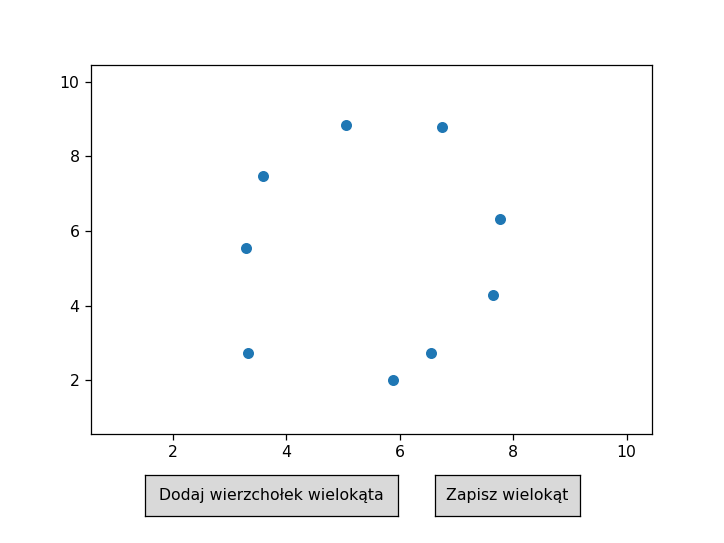

In [23]:
%matplotlib notebook
plots = PlotGetFigure()
plots.draw()

#### Przedstawienie wynikowej figury i efektu analizy na monotoniczność

jest Y monotoniczny


<IPython.core.display.Javascript object>


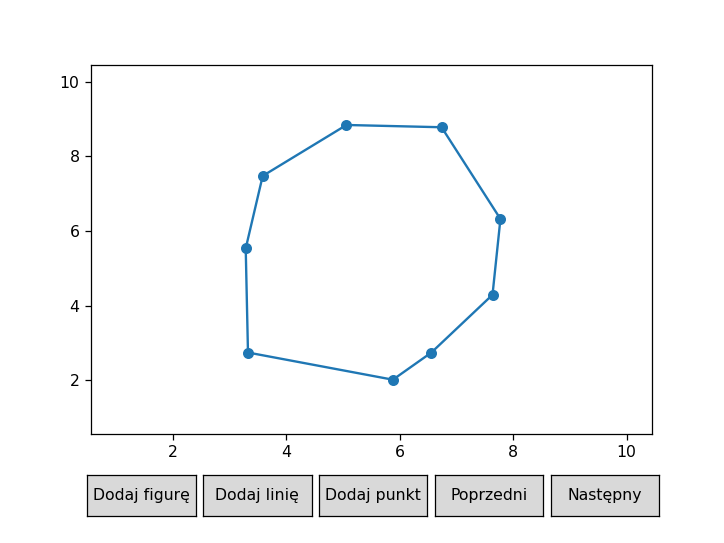

In [24]:
if (type(plots) == PlotGetFigure):
    plots.figure_return()
linie = LinesFromPoints(PlotGetFigure.figure)
punkty = PlotGetFigure.figure
defaultPoints = PointsCollection([(1,1), (10,10), (1, 10),(10, 1)],color = "white",marker="s")
plot = Plot(points = [PointsCollection(punkty),defaultPoints],lines=[LinesCollection(linie)])
if Ymonotone(punkty):
    print("jest Y monotoniczny")
    
else:
    print("nie jest y monotoniczny")

plot.draw()

#### Przedstawienie krok po kroku procesu kolorowania wierzchołków
#### każda scena odpowiada pokolorowaniu jednego wierzchołka

<IPython.core.display.Javascript object>


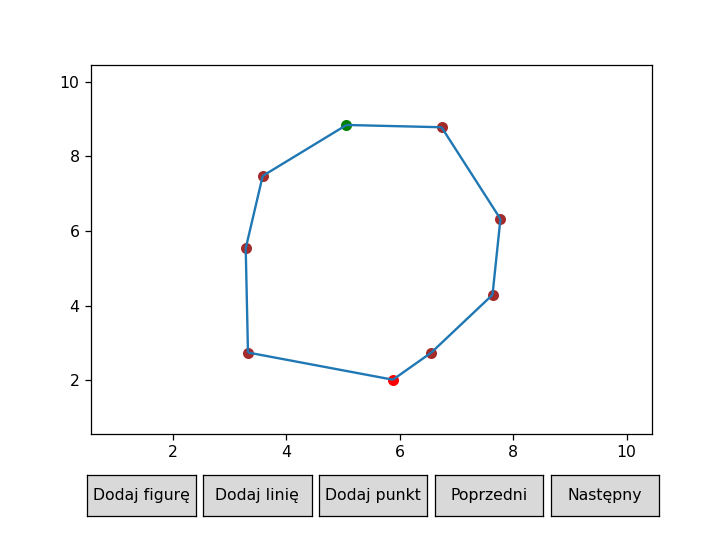

In [25]:
if (type(plots) == PlotGetFigure):
    plots.figure_return()
linie = LinesFromPoints(PlotGetFigure.figure)
punkty = PlotGetFigure.figure
sceny = TypeColor(punkty,linie)
plot = Plot(sceny)
plot.draw()


#### Przedstawienie wyniku kolorowania poszczególnych łańcuchów

<IPython.core.display.Javascript object>


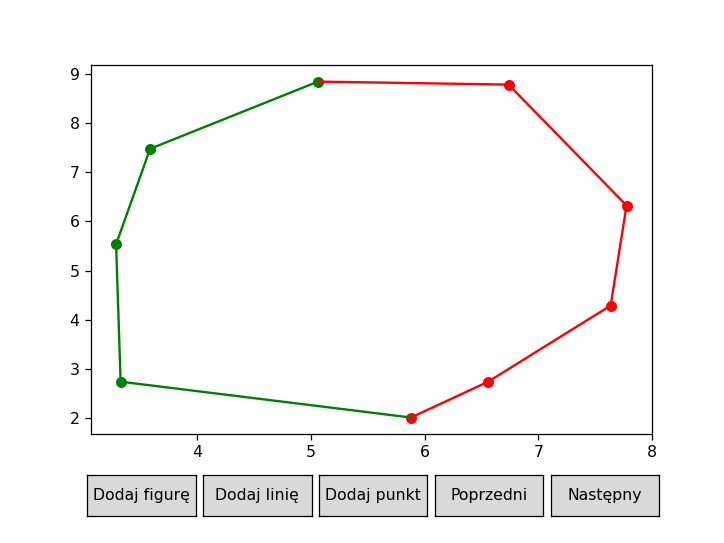

In [27]:
points = leftRightString(punkty)
linie = twoStringToLines(points[0].points,points[1].points)
plot = Plot(points = points,lines=linie)
plot.draw()

#### Gotowy algorytm triangulacji wraz z wizualizacją poprzednich kroków
##### oznaczenia wierzchołków:
<span style="color:red">Wierzchołek Końcowy</span><br>
<span style="color:royalblue">Wierzchołek Dzielący</span><br>
<span style="color:darkblue">Wierzchołek Łączący</span><br>
<span style="color:green">Wierzchołek Początkowy</span><br>
<span style="color:brown">Wierzchołek prawidłowy</span><br>
<span style="color:pink">Wierzchołek znajdujący się na stosie</span><br>
##### oznaczenia krawędzi:
<span style="color:red">Łańcuch Lewy</span><br>
<span style="color:green">Łańcuch Prawy</span><br>



jest Y monotoniczny


<IPython.core.display.Javascript object>


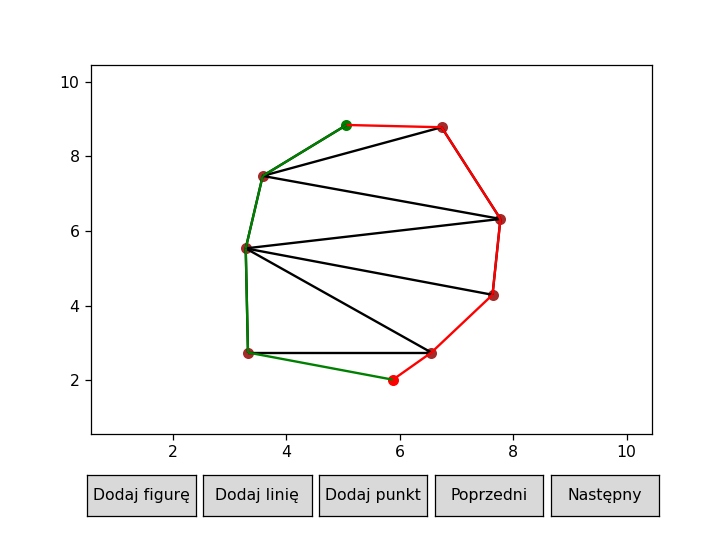

In [32]:
wynik = Plot(traiangulacja(punkty))
wynik.draw()